# Goal

In this notebook, we want to try to derive the gravitational wave signal from the noisy data, given our own noise power spectrum via a parametric wavelet model and variational inference.

In [1]:
from scipy.signal import envelope
# %matplotlib tk
from config_jupyter_notebooks import *

Important variables: 
		signal_strip_time, signal_strip_strain 
		signal_strip_strain_tapered
		strain
		time_domain_strip
		N


In [2]:

def wavy_signal(t, peak_pos=0.0, max_amp=1.0, width=1.0, freq_func=None):
    """
    Generate a wavy signal with a variable amplitude envelope and varying wavelength.

    Parameters:
        t (array): Time array
        peak_pos (float): Center of the amplitude envelope
        max_amp (float): Maximum amplitude of the envelope
        width (float): Controls the width of the envelope
        freq_func (callable): Function defining instantaneous frequency vs time

    Returns:
        array: The modulated wavy signal
    """
    # Asymmetrical Gaussian envelope
    envelope = max_amp * np.exp(-((t - peak_pos) / width)**2 * (1 + 0.5 * np.tanh(t - peak_pos)))

    # Instantaneous phase for varying frequency
    if freq_func is None:
        freq_func = lambda t: 2 + np.sin(t)  # Default frequency variation

    phase = 2 * np.pi * np.cumsum(freq_func(t)) * (t[1] - t[0])  # Integrate frequency to get phase
    signal = envelope * np.sin(1e3*phase)

    return signal


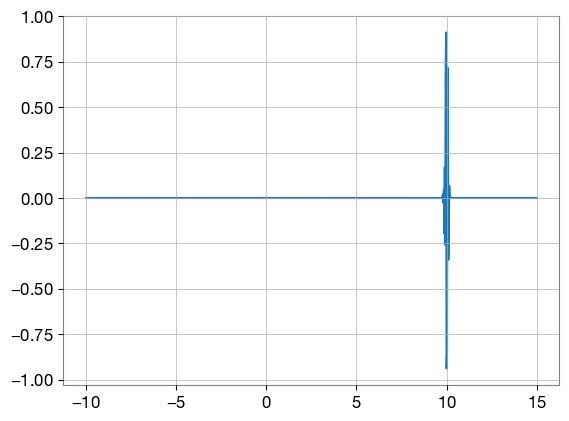

In [3]:
plt.figure()
x = np.linspace(-10, 15, 1000)
y =  wavy_signal(x, peak_pos=10, width=0.1)
plt.plot(x, y)
plt.show()

In [4]:
def generative_model(extended_time_domain, extended_time_domain_values):

    mean_peak_pos = 16.4
    fac = 3
    mean_peak_pos -= fac
    peak_pos = ift.NormalTransform(-mean_peak_pos, 0.3, key="mean peak pos ")
    max_amp = ift.NormalTransform(4, 1e-16, key="max amplitude ")
    width = ift.NormalTransform(0.1, 1e-1, key="packet width ")

    num = len(extended_time_domain_values)
    tmp = np.linspace(-7+mean_peak_pos+fac, 7+mean_peak_pos+fac, num)

    # x_field = ift.Field(ift.DomainTuple.make(extended_time_domain), val=extended_time_domain_values)
    x_field = ift.Field(ift.DomainTuple.make(extended_time_domain), val=tmp)
    expander = ift.ContractionOperator(spaces=None, domain=ift.DomainTuple.make(extended_time_domain)).adjoint
    peak_pos, max_amp, width = [expander @ el for el in [peak_pos, max_amp, width]]

    # Asymmetrical Gaussian envelope
    # term1 =  -((t - peak_pos) / width)**2
    # term2 = (1 + 0.5 * np.tanh(t - peak_pos))
    # kernel = term1 * term2
    # envelope = max_amp * np.exp(kernel)

    x_adder = ift.Adder(x_field)
    shifted_field = x_adder @ peak_pos

    # Subtraction: Pointwise operator subtraction => HAVE to have the same domains. Is done in place, now.
    # Chaining via add operator: Domain of add operator has to be TARGET of inner operator. Obviously.
    # and expander maps from scalar domain to RGSpace by returning a field full of one scalar value.

    term1 = -(shifted_field * width.ptw("reciprocal"))**2

    add_one = ift.Adder(ift.Field(ift.DomainTuple.make(extended_time_domain), val=np.ones(len(x_field.val))))
    term2 = add_one @ (0.5*shifted_field.ptw("tanh"))

    kernel = term1 * term2
    envelope = max_amp * kernel.ptw("exp")

    freq_func = lambda arg: 2 + np.sin(arg)

    small_scale_oscillation = 1e1  # the higher the number, the more short time scale oscillations
    phase = np.sin(small_scale_oscillation*(2 * np.pi * np.cumsum(freq_func(x_field.val)) * (x_field.val[1] - x_field.val[0])))  # Integrate frequency to get phase
    phase_diag = ift.DiagonalOperator(ift.Field(ift.DomainTuple.make(extended_time_domain), val=phase))
    signal = phase_diag @ envelope

    return signal

s = generative_model

In [5]:

inference_scheme = ExecuteRGSpaceKL(
    custom_data_space = N.domain[0],
    discrete_time=signal_strip_time,
    d=signal_strip_strain_tapered,
    cfm_model_name="GW parametric wavelet model ",
    kl_minimizations=5,
    fluct=(8, 1),
    llslope=(-4, 0.5),
    gaussian_noise_level=None,
    custom_noise_operator=N,
    out_dir_name="parametric_wavelet_model_out",
    custom_generative_model=s
)

Number of datapoints:  8191
Constructing RGspace of this number of points:  16382  (not extended)
Based on sampling rate, length and shape of domain, keeping  8191  points of continuous signal.


[<nifty8.Field>, <nifty8.Field>, <nifty8.Field>]

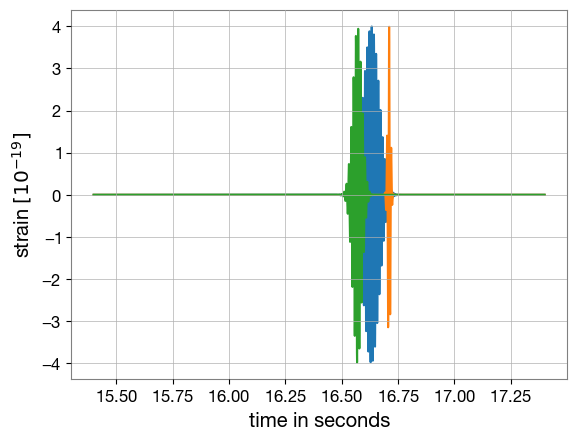

In [6]:
plt.figure()
inference_scheme.plot_prior_samples(3)
# sl = inference_scheme.model(ift.from_random(inference_scheme.model.domain))
# tmp = np.linspace(-7+16.4, 7+16.4, len(sl.val))
# plt.plot(tmp, sl.val)

In [7]:
inference_scheme.run()

Creating Gaussian likelihood...
Created Gaussian likelihood, running KL.
Posterior samples saved. Analyze via class.plot_posterior()


chi_sq reduced in dataspace:  3.419526112148783


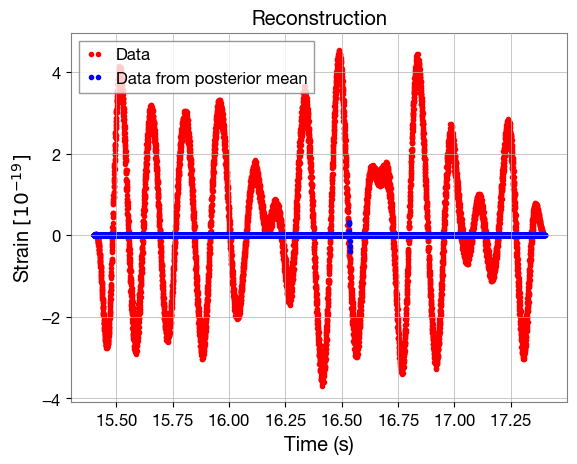

In [8]:
plt.figure()
inference_scheme.plot_posterior(plot_signal_space=False)

Ok so this obviously does not work. Let's try out Torsten's method by getting the signal power spectrum from a numerical relativity template

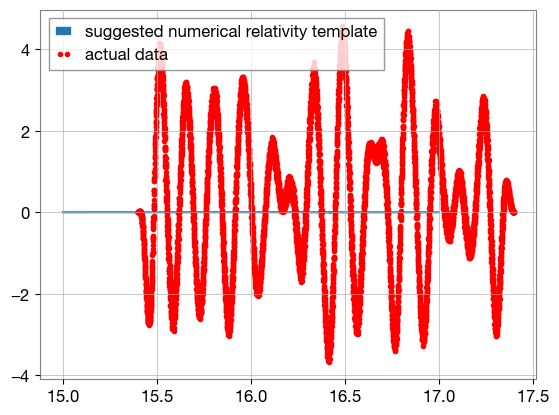

In [9]:
# Numerical Relativity Template
plt.figure()
nrt_strain_values = np.loadtxt("num_rel_template_strain_values.txt") * 1e19
nrt_time_values = np.loadtxt("num_rel_template_time_values.txt") - zero_time

plt.plot(nrt_time_values, nrt_strain_values, label="suggested numerical relativity template")
plt.plot(signal_strip_time, signal_strip_strain_tapered, "r.", label="actual data")
plt.legend()
plt.show()


In [10]:
def generative_model_2(extended_time_domain, extended_time_domain_values):

    nrt_strain_values_copy = nrt_strain_values
    nrt_time_values_copy = nrt_time_values

    idcs_to_cut = np.where(nrt_time_values < np.min(signal_strip_time))
    nrt_strain_values_copy = np.delete(nrt_strain_values_copy, idcs_to_cut)
    nrt_time_values_copy = np.delete(nrt_time_values_copy, idcs_to_cut)

    len_difference = len(signal_strip_time) - len(nrt_time_values_copy)
    nrt_strain_values_copy = np.append(nrt_strain_values_copy, np.zeros(len_difference)).flatten()

    # now interpolate extended domain array
    interpolated_strain_values_large_domain = np.interp(extended_time_domain_values, signal_strip_time, nrt_strain_values_copy)

    # plt.figure()
    # plt.vlines([16.3, 16.45], -4, 4, ls="--", label="Where the peak should be ")
    # # plt.plot(signal_strip_time, signal_strip_strain_tapered, "r.", label="actual data")
    # plt.plot(extended_time_domain_values, interpolated_strain_values_large_domain, label= "NR template")
    # # plt.plot(nrt_time_values_copy, nrt_strain_values_copy)
    # plt.legend()
    # plt.show()

    amp = ift.NormalTransform(mean=1, sigma=1e-16, key="amplitude ")
    expander = ift.ContractionOperator(extended_time_domain, spaces=0).adjoint
    amp = expander @ amp

    strain_values = ift.DiagonalOperator(ift.Field(ift.DomainTuple.make(extended_time_domain), val=interpolated_strain_values_large_domain))

    return strain_values @ amp

s_num_real = generative_model_2


In [11]:

inference_scheme_2 = ExecuteRGSpaceKL(
    custom_data_space = N.domain[0],
    discrete_time=signal_strip_time,
    d=signal_strip_strain_tapered,
    cfm_model_name="GW numerical wavelet model ",
    kl_minimizations=5,
    fluct=(8, 1),
    llslope=(-4, 0.5),
    gaussian_noise_level=None,
    custom_noise_operator=N,
    out_dir_name="numerical_wavelet_model_out3",
    custom_generative_model=s_num_real
)

Number of datapoints:  8191
Constructing RGspace of this number of points:  16382  (not extended)
Based on sampling rate, length and shape of domain, keeping  8191  points of continuous signal.


In [12]:
inference_scheme_2.run()

Creating Gaussian likelihood...
Created Gaussian likelihood, running KL.
Posterior samples saved. Analyze via class.plot_posterior()


chi_sq reduced in dataspace:  1.068232317799025


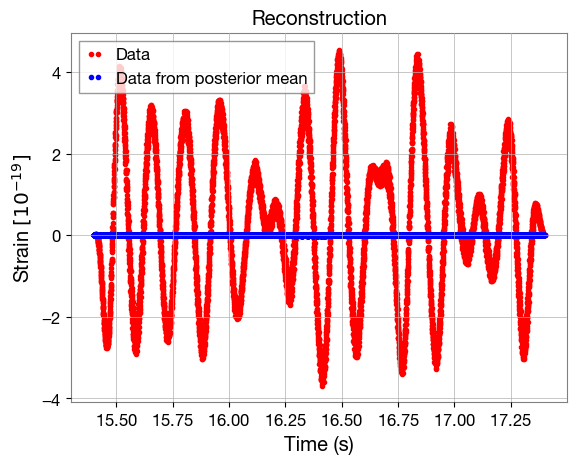

In [13]:
# run with uncertainty of amplitude set to 1e-16 => chi^2 of 1.1 but line search algorithm not converging ; Energy not changing.
inference_scheme_2.plot_posterior()

In [14]:
def generative_model_3(extended_time_domain, extended_time_domain_values):
    """

    Generative model of numerical wavelet template with adjustable max height and position of peak

    :param extended_time_domain:
    :param extended_time_domain_values:
    :return:
    """

    # --- get numerical relativity template and cut it so it fits to the time domain --- #
    nrt_strain_values_copy = nrt_strain_values
    nrt_time_values_copy = nrt_time_values

    idcs_to_cut = np.where(nrt_time_values < np.min(signal_strip_time))
    nrt_strain_values_copy = np.delete(nrt_strain_values_copy, idcs_to_cut)
    nrt_time_values_copy = np.delete(nrt_time_values_copy, idcs_to_cut)

    len_difference = len(signal_strip_time) - len(nrt_time_values_copy)
    nrt_strain_values_copy = np.append(nrt_strain_values_copy, np.zeros(len_difference)).flatten()

    # now interpolate extended domain array
    interpolated_strain_values_large_domain = np.interp(extended_time_domain_values, signal_strip_time, nrt_strain_values_copy)

    # --- --- #

    amp = ift.NormalTransform(mean=5*1e2, sigma=1e2, key="amplitude ")
    shift = ift.NormalTransform(mean=2, sigma=4, key="shift ")

    expander = ift.ContractionOperator(extended_time_domain, spaces=0).adjoint
    amp = expander @ amp
    shift = expander @ shift

    strain_values = ift.DiagonalOperator(ift.Field(ift.DomainTuple.make(extended_time_domain), val=interpolated_strain_values_large_domain))

    return strain_values @ amp

s_num_real_2 = generative_model_3


In [15]:

inference_scheme_3 = ExecuteRGSpaceKL(
    custom_data_space = N.domain[0],
    discrete_time=signal_strip_time,
    d=signal_strip_strain_tapered,
    cfm_model_name="GW numerical wavelet model ",
    kl_minimizations=5,
    fluct=(8, 1),
    llslope=(-4, 0.5),
    gaussian_noise_level=None,
    custom_noise_operator=N,
    out_dir_name="numerical_wavelet_model_out6",
    custom_generative_model=s_num_real_2
)

Number of datapoints:  8191
Constructing RGspace of this number of points:  16382  (not extended)
Based on sampling rate, length and shape of domain, keeping  8191  points of continuous signal.


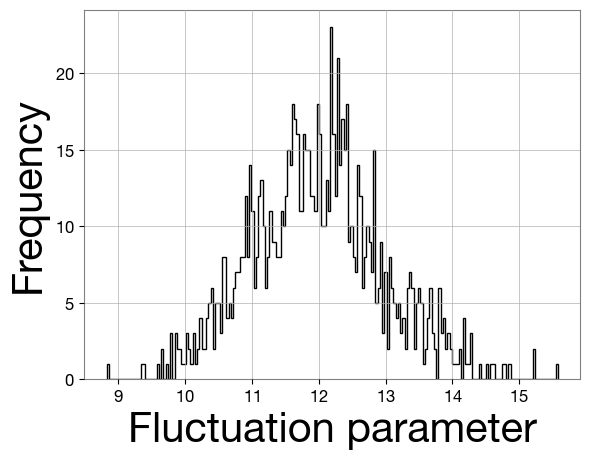

In [16]:
inference_scheme_3.plot_prior_fluctuations_distribution()

In [18]:

%matplotlib tk
tmp = inference_scheme_3.plot_prior_samples(50, apply_adjoint_zp=True, supress_plot=True)
mean = np.mean([el.val for el in tmp], axis=0)
plt.plot(inference_scheme_3.domain_values.val, mean)

inference_scheme_3.run()

Creating Gaussian likelihood...
Created Gaussian likelihood, running KL.


The line search algorithm (zoom) did not converge.
The line search algorithm (zoom) did not converge.
                     reduced χ²          mean      # dof
--------------------------------------------------------
Data residuals
  <None>              1.1 ± 0.0    -0.0 ± 0.0       8191
Latent space
  amplitude          24.9 ± 0.0    -5.0 ± 0.0          1
The line search algorithm (zoom) did not converge.
The line search algorithm (zoom) did not converge.
The line search algorithm (zoom) did not converge.
The line search algorithm (zoom) did not converge.
The line search algorithm (zoom) did not converge.
The line search algorithm (zoom) did not converge.
The line search algorithm (zoom) did not converge.
The line search algorithm (zoom) did not converge.
The line search algorithm (zoom) did not converge.
The line search algorithm (zoom) did not converge.
The line search algorithm (zoom) did not converge.
The line search algorithm (zoom) did not converge.
The line search algorithm (zoo

Posterior samples saved. Analyze via class.plot_posterior()


In [19]:
%matplotlib tk
tmp = inference_scheme_3.plot_prior_samples(5, apply_adjoint_zp=True)
plt.show()

mean = np.mean([el.val for el in tmp], axis=0)

In [20]:
plt.plot(nrt_time_values, nrt_strain_values, label="suggested numerical relativity template")
plt.plot(inference_scheme_3.domain_values.val, mean, label="Prior mean")
inference_scheme_3.plot_posterior(plot_signal_space=True, plot_with_variance=True)


In [20]:
OBACHT: N IN MEINEN NORMIERUNGEN MUSS N VOM FELD SEIN ALSO N_PIX NICHT N_DTPS, TUE ICH DAS?

Object `DAS` not found.
